In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import json
import gpplot as gpp
gpp.set_aesthetics(context = 'paper')

In [14]:
def is_distance_less_than_x(row1, row2, start , end, x ):
    row2_range = range(int(row2[start]), int(row2[end]))
    #print(row1['Strand'])

    if row1['Strand'] == 1:
        start_row1_minus_end_row2 = abs(float(row1[start]) - float(row2[end]))
        start_row1_minus_start_row2 = abs(float(row1[start]) - float(row2[start]))
        start_row1_between_row2 = int(row1[start]) in row2_range
        return start_row1_minus_end_row2 < x or start_row1_minus_start_row2 < x or start_row1_between_row2
   
    elif row1['Strand'] == -1:
        end_row1_minus_start_row2 = abs(float(row1[end]) - float(row2[start]))
        end_row1_minus_end_row2 = abs(float(row1[end]) - float(row2[end]))
        end_row1_between_row2 = int(row1[end]) in row2_range
        return end_row1_minus_start_row2 < x or end_row1_minus_end_row2 < x or end_row1_between_row2
    else:
        raise Exception("The strand is neither 1 nor -1. Review is_distance_less_than_x!")

def add_element(dict, key, value):
    #https://stackoverflow.com/questions/33272588/appending-elements-to-an-empty-dictionary-of-lists-in-python
    if key not in dict:
        dict[key] = []
    if value not in dict[key]:  # Check if the value is not already in the list
        dict[key].append(value)

        
        
def overlap_list(biomart_df, start = 'Gene start (bp)', end = 'Gene end (bp)', x = 1000):
    filtered_objects = dict()

    for chromo in biomart_df['Chromosome/scaffold name'].unique():
        print(chromo)

    # select choromosom
        c1 = biomart_df[biomart_df['Chromosome/scaffold name'] == chromo]
#         # esstential gene in the chromosome
#         ess_gene_c1 = c1[c1['Gene name'].isin(ess_gene_list)]
        # Filter the DataFrame

        for i, row1 in c1.iterrows():
            for j, row2 in c1.iterrows():
                if i != j:
                    if is_distance_less_than_x(row1, row2, start = start, end = end, x = x):
                        add_element(filtered_objects, row1['Gene stable ID'], row2['Gene stable ID'])
                    else:
                        pass
    return filtered_objects
# Convert the dictionary into a list of tuples 
# then into df then melt datframe
def dict_to_df(example_dict):
    test_gene_overlap = []
    for key, value_list in example_dict.items():
        for value in value_list:
            test_gene_overlap.append((key, value))
    
    example_dict_data = pd.DataFrame(test_gene_overlap, columns=['Selected Gene', 'Overlapping Gene'])
    example_dict_data = example_dict_data.drop_duplicates()
    return example_dict_data

                    
def overlap_type(gene_1, gene_2, x = 1000):   

    # gene_1 and gene_2 are rows 
    if (float(gene_1['Strand'].iloc[0]) == 1) and (float(gene_2['Strand'].iloc[0]) == -1):
        distance_tss = abs(float(gene_1['Gene start (bp)'].iloc[0]) - float(gene_2['Gene end (bp)'].iloc[0]))
        other_distance_tss = abs(float(gene_1['Gene start (bp)'].iloc[0]) - float(gene_2['Gene start (bp)'].iloc[0]))

        if distance_tss <= x:
            return 2
        else:
            if other_distance_tss <= x:
                return 4
            else:
                return 5

    if (float(gene_1['Strand'].iloc[0]) == 1) and (float(gene_2['Strand'].iloc[0]) == 1):
        distance_tss = abs(float(gene_1['Gene start (bp)'].iloc[0]) - float(gene_2['Gene start (bp)'].iloc[0]))
        other_distance_tss_case1 = abs(float(gene_1['Gene start (bp)'].iloc[0]) - float(gene_2['Gene end (bp)'].iloc[0]))
        other_distance_tss_case2 = abs(float(gene_2['Gene start (bp)'].iloc[0]) - float(gene_1['Gene end (bp)'].iloc[0]))


        if distance_tss <= x:
            return 3
        else:

            if (other_distance_tss_case1 <= x) or (other_distance_tss_case2 <= x):
                return 1
            else:
                return 6
    
    if (float(gene_1['Strand'].iloc[0]) == -1) and (float(gene_2['Strand'].iloc[0]) == 1):
        distance_tss =  abs(float(gene_2['Gene start (bp)'].iloc[0]) - float(gene_1['Gene end (bp)'].iloc[0]))
        other_distance_tss = abs(float(gene_2['Gene start (bp)'].iloc[0]) - float(gene_1['Gene start (bp)'].iloc[0]))

        if distance_tss <= x:
            return 2
        else:
            if other_distance_tss <= x:
                return 4
            else:
                return 5
    if (float(gene_1['Strand'].iloc[0]) == -1) and (float(gene_2['Strand'].iloc[0]) == -1):
        distance_tss = abs(float(gene_1['Gene end (bp)'].iloc[0]) - float(gene_2['Gene end (bp)'].iloc[0]))
        other_distance_tss_case1 = abs(float(gene_1['Gene end (bp)'].iloc[0]) - float(gene_2['Gene start (bp)'].iloc[0]))
        other_distance_tss_case2 = abs(float(gene_2['Gene end (bp)'].iloc[0]) - float(gene_1['Gene start (bp)'].iloc[0]))

        if distance_tss <= x:
            return 3
        else:

            if (other_distance_tss_case1 <= x) or (other_distance_tss_case2 <= x):
                return 1
            else:
                return 6
                        


In [96]:
#import biomart export
file_path = '../../Data/geneOverlap/'
biomart = pd.read_table(file_path + 'mart_export_genome_wide_01032024.txt', sep = ',', low_memory=False)
biomart

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene type,Gene name,Gene description,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Transcription start site (TSS),Strand,Transcript start (bp),Transcript end (bp)
0,ENSG00000210049,ENSG00000210049.1,ENST00000387314,ENST00000387314.1,Mt_tRNA,MT-TF,mitochondrially encoded tRNA-Phe (UUU/C) [Sour...,MT,577,647,577,1,577,647
1,ENSG00000211459,ENSG00000211459.2,ENST00000389680,ENST00000389680.2,Mt_rRNA,MT-RNR1,mitochondrially encoded 12S rRNA [Source:HGNC ...,MT,648,1601,648,1,648,1601
2,ENSG00000210077,ENSG00000210077.1,ENST00000387342,ENST00000387342.1,Mt_tRNA,MT-TV,mitochondrially encoded tRNA-Val (GUN) [Source...,MT,1602,1670,1602,1,1602,1670
3,ENSG00000210082,ENSG00000210082.2,ENST00000387347,ENST00000387347.2,Mt_rRNA,MT-RNR2,mitochondrially encoded 16S rRNA [Source:HGNC ...,MT,1671,3229,1671,1,1671,3229
4,ENSG00000209082,ENSG00000209082.1,ENST00000386347,ENST00000386347.1,Mt_tRNA,MT-TL1,mitochondrially encoded tRNA-Leu (UUA/G) 1 [So...,MT,3230,3304,3230,1,3230,3304
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276900,ENSG00000116786,ENSG00000116786.13,ENST00000375799,ENST00000375799.8,protein_coding,PLEKHM2,pleckstrin homology and RUN domain containing ...,1,15684320,15734769,15684320,1,15684320,15734769
276901,ENSG00000116786,ENSG00000116786.13,ENST00000375793,ENST00000375793.2,protein_coding,PLEKHM2,pleckstrin homology and RUN domain containing ...,1,15684320,15734769,15684390,1,15684390,15734769
276902,ENSG00000116786,ENSG00000116786.13,ENST00000462455,ENST00000462455.1,protein_coding,PLEKHM2,pleckstrin homology and RUN domain containing ...,1,15684320,15734769,15684541,1,15684541,15719869
276903,ENSG00000116786,ENSG00000116786.13,ENST00000642363,ENST00000642363.1,protein_coding,PLEKHM2,pleckstrin homology and RUN domain containing ...,1,15684320,15734769,15684556,1,15684556,15734769


In [97]:
#limit to chromosomes (remove unlocalized contigs/scaffolds)
chromo1_22 = [str(num) for num in range(1, 23)]
biomart = biomart[biomart['Chromosome/scaffold name'].isin(chromo1_22+['X','Y'])].copy()
#subset to protein coding genes
biomart_protein_coding = biomart[biomart['Gene type'] == 'protein_coding'].copy()
#drop duplicates
proteinCodingGeneNoDup = biomart_protein_coding.drop_duplicates('Gene stable ID')
proteinCodingGeneNoDup

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene type,Gene name,Gene description,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Transcription start site (TSS),Strand,Transcript start (bp),Transcript end (bp)
239,ENSG00000169789,ENSG00000169789.10,ENST00000303728,ENST00000303728.5,protein_coding,PRY,PTPN13 like Y-linked [Source:HGNC Symbol;Acc:H...,Y,22490397,22514637,22490397,1,22490397,22514637
262,ENSG00000114374,ENSG00000114374.13,ENST00000457658,ENST00000457658.6,protein_coding,USP9Y,ubiquitin specific peptidase 9 Y-linked [Sourc...,Y,12537650,12860839,12537650,1,12537650,12708869
295,ENSG00000169807,ENSG00000169807.10,ENST00000303804,ENST00000303804.5,protein_coding,PRY2,PTPN13 like Y-linked 2 [Source:HGNC Symbol;Acc...,Y,22071756,22096007,22096007,-1,22071756,22096007
313,ENSG00000198692,ENSG00000198692.10,ENST00000361365,ENST00000361365.7,protein_coding,EIF1AY,eukaryotic translation initiation factor 1A Y-...,Y,20575776,20593154,20575776,1,20575776,20593154
319,ENSG00000183753,ENSG00000183753.10,ENST00000602732,ENST00000602732.5,protein_coding,BPY2,basic charge Y-linked 2 [Source:HGNC Symbol;Ac...,Y,22973819,23005465,22973819,1,22973819,22992376
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276873,ENSG00000116138,ENSG00000116138.13,ENST00000375838,ENST00000375838.5,protein_coding,DNAJC16,DnaJ heat shock protein family (Hsp40) member ...,1,15526813,15592379,15526813,1,15526813,15566595
276885,ENSG00000116771,ENSG00000116771.6,ENST00000375826,ENST00000375826.4,protein_coding,AGMAT,agmatinase [Source:HGNC Symbol;Acc:HGNC:18407],1,15571699,15585051,15585051,-1,15571699,15585051
276890,ENSG00000197312,ENSG00000197312.13,ENST00000711098,ENST00000711098.1,protein_coding,DDI2,DNA damage inducible 1 homolog 2 [Source:HGNC ...,1,15617458,15669044,15617458,1,15617458,15669044
276898,ENSG00000215695,ENSG00000215695.2,ENST00000345034,ENST00000345034.2,protein_coding,RSC1A1,regulator of solute carriers 1 [Source:HGNC Sy...,1,15659713,15662033,15659713,1,15659713,15662033


In [22]:
#create list of overlapping genes

# ensembl_protein_coding_gene_list = overlap_list(proteinCodingGeneNoDup, 
#                                                 start = 'Gene start (bp)', 
#                                                 end = 'Gene end (bp)', 
#                                                 x = 1000)

# # with open('../../Data/geneOverlap/all_tss_overlap_list.json', 'w') as file:
# #     json.dump(ensembl_protein_coding_gene_list, file)

In [63]:
#subset to just MANE Select TSSs
gencode48 = pd.read_csv('../../Data/GENCODE48/gencode_48_protein_coding_transcripts.csv')
mane_transcripts = gencode48[gencode48['tag'].str.contains('MANE_Select') == True]['transcript_id_without_version'].tolist()
biomart_mane = biomart[biomart['Transcript stable ID'].isin(mane_transcripts)].copy()
biomart_mane

,Gene stable ID,Gene stable ID version,Transcript stable ID,Transcript stable ID version,Gene type,Gene name,Gene description,Chromosome/scaffold name,Gene start (bp),Gene end (bp),Transcription start site (TSS),Strand,Transcript start (bp),Transcript end (bp)
266,ENSG00000114374,ENSG00000114374.13,ENST00000338981,ENST00000338981.7,protein_coding,USP9Y,ubiquitin specific peptidase 9 Y-linked [Sourc...,Y,12537650,12860839,12701231,1,12701231,12860839
313,ENSG00000198692,ENSG00000198692.10,ENST00000361365,ENST00000361365.7,protein_coding,EIF1AY,eukaryotic translation initiation factor 1A Y-...,Y,20575776,20593154,20575776,1,20575776,20593154
320,ENSG00000183753,ENSG00000183753.10,ENST00000331070,ENST00000331070.8,protein_coding,BPY2,basic charge Y-linked 2 [Source:HGNC Symbol;Ac...,Y,22973819,23005465,22984263,1,22984263,23005465
405,ENSG00000236424,ENSG00000236424.7,ENST00000428845,ENST00000428845.6,protein_coding,TSPY10,testis specific protein Y-linked 10 [Source:HG...,Y,9527880,9530682,9527880,1,9527880,9530676
430,ENSG00000258992,ENSG00000258992.7,ENST00000451548,ENST00000451548.6,protein_coding,TSPY1,testis specific protein Y-linked 1 [Source:HGN...,Y,9466955,9469749,9466955,1,9466955,9469749
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
276877,ENSG00000116138,ENSG00000116138.13,ENST00000375847,ENST00000375847.8,protein_coding,DNAJC16,DnaJ heat shock protein family (Hsp40) member ...,1,15526813,15592379,15526848,1,15526848,15571733
276885,ENSG00000116771,ENSG00000116771.6,ENST00000375826,ENST00000375826.4,protein_coding,AGMAT,agmatinase [Source:HGNC Symbol;Acc:HGNC:18407],1,15571699,15585051,15585051,-1,15571699,15585051
276892,ENSG00000197312,ENSG00000197312.13,ENST00000480945,ENST00000480945.6,protein_coding,DDI2,DNA damage inducible 1 homolog 2 [Source:HGNC ...,1,15617458,15669044,15617458,1,15617458,15669044
276898,ENSG00000215695,ENSG00000215695.2,ENST00000345034,ENST00000345034.2,protein_coding,RSC1A1,regulator of solute carriers 1 [Source:HGNC Sy...,1,15659713,15662033,15659713,1,15659713,15662033


In [72]:
mane_tss_overlap_list = overlap_list(biomart_mane, 
                                     start = 'Transcript start (bp)', 
                                     end = 'Transcript end (bp)', 
                                     x = 1000)

with open('../../Data/geneOverlap/mane_tss_overlap_list.json', 'w') as file:
    json.dump(mane_tss_overlap_list, file)

Y
13
21
18
20
22
14
X
8
15
9
10
16
5
6
4
7
12
19
11
17
3
2
1


### Scale of overlap when considering every Ensembl TSS per gene

In [65]:
with open('../../Data/geneOverlap/all_tss_overlap_list.json', 'r') as file:
    GW_ensembl_protein_coding = json.load(file)
GW_ensembl_protein_coding_df = dict_to_df(GW_ensembl_protein_coding)
GW_ensembl_protein_coding_df

,Selected Gene,Overlapping Gene
0,ENSG00000099721,ENSG00000092377
1,ENSG00000092377,ENSG00000099721
2,ENSG00000292345,ENSG00000292338
3,ENSG00000132952,ENSG00000189403
4,ENSG00000189403,ENSG00000132952
...,...,...
7721,ENSG00000215704,ENSG00000142615
7722,ENSG00000132906,ENSG00000116138
7723,ENSG00000116138,ENSG00000132906
7724,ENSG00000116771,ENSG00000116138


In [66]:
total_gene = list(GW_ensembl_protein_coding_df['Selected Gene']) + list(GW_ensembl_protein_coding_df['Overlapping Gene'])

print(f'There are {len(set(total_gene))} genes with at least one overlap.')
print(f'This {100*(len(set(total_gene))/20033)} percent of total genes.')

There are 7218 genes with at least one overlap.
This 36.030549593171266 percent of total genes.


In [67]:
# merge Overlapping gene
GW_ensembl_protein_coding_df = pd.merge(GW_ensembl_protein_coding_df,
         proteinCodingGeneNoDup[['Gene stable ID', 'Strand', 'Gene name','Gene start (bp)', 
                                'Gene end (bp)']].rename(columns = {'Gene stable ID': 'Overlapping Gene',
                                                            'Strand': 'Overlapping Strand', 
                                                              'Gene name': 'Overlapping Gene name',
                                                              'Gene start (bp)': 'Overlapping Gene start (bp)', 
                                                              'Gene end (bp)': 'Overlapping Gene end (bp)' }))



In [68]:
# merge Selected gene
GW_ensembl_protein_coding_df = pd.merge(GW_ensembl_protein_coding_df,
         proteinCodingGeneNoDup[['Gene stable ID', 'Strand', 'Gene name','Gene start (bp)', 
                                'Gene end (bp)']].rename(columns = {'Gene stable ID': 'Selected Gene',
                                                            'Strand': 'Selected Strand', 
                                                              'Gene name': 'Selected Gene name',
                                                              'Gene start (bp)': 'Selected Gene start (bp)', 
                                                              'Gene end (bp)': 'Selected Gene end (bp)' }))

In [69]:
for index, row in GW_ensembl_protein_coding_df.iterrows():
    gene_name_1 = row['Selected Gene']
    gene_name_2 = row['Overlapping Gene']
    gene_name_1_row = proteinCodingGeneNoDup[proteinCodingGeneNoDup['Gene stable ID'].isin([gene_name_1])]
    gene_name_2_row = proteinCodingGeneNoDup[proteinCodingGeneNoDup['Gene stable ID'].isin([gene_name_2])]
    overlap_type_number = overlap_type(gene_name_1_row, gene_name_2_row)
    GW_ensembl_protein_coding_df.loc[index,'overlap type'] = overlap_type_number

In [70]:
GW_ensembl_protein_coding_df.head()

,Selected Gene,Overlapping Gene,Overlapping Strand,Overlapping Gene name,Overlapping Gene start (bp),Overlapping Gene end (bp),Selected Strand,Selected Gene name,Selected Gene start (bp),Selected Gene end (bp),overlap type
0,ENSG00000099721,ENSG00000092377,1,TBL1Y,6910686,7101970,-1,AMELY,6865918,6911752,5.0
1,ENSG00000092377,ENSG00000099721,-1,AMELY,6865918,6911752,1,TBL1Y,6910686,7101970,5.0
2,ENSG00000292345,ENSG00000292338,-1,DHRSX,2219506,2502805,-1,ZBED1,2486414,2500976,6.0
3,ENSG00000132952,ENSG00000189403,-1,HMGB1,30456704,30617597,1,USPL1,30617693,30660770,2.0
4,ENSG00000189403,ENSG00000132952,1,USPL1,30617693,30660770,-1,HMGB1,30456704,30617597,2.0


In [71]:
GW_ensembl_protein_coding_df.to_csv('../../Data/geneOverlap/GW_ensembl_protein_coding_df_1kb.csv', index = False)

### Scale of overlap between MANE Select TSSs

In [73]:
with open('../../Data/geneOverlap/mane_tss_overlap_list.json', 'r') as file:
    GW_mane_protein_coding = json.load(file)
GW_mane_protein_coding_df = dict_to_df(GW_mane_protein_coding)
GW_mane_protein_coding_df

,Selected Gene,Overlapping Gene
0,ENSG00000099721,ENSG00000092377
1,ENSG00000092377,ENSG00000099721
2,ENSG00000102547,ENSG00000136169
3,ENSG00000204899,ENSG00000136122
4,ENSG00000120685,ENSG00000188811
...,...,...
3155,ENSG00000197982,ENSG00000196449
3156,ENSG00000132128,ENSG00000173660
3157,ENSG00000173660,ENSG00000132128
3158,ENSG00000132781,ENSG00000132773


In [74]:
total_gene = list(GW_mane_protein_coding_df['Selected Gene']) + list(GW_mane_protein_coding_df['Overlapping Gene'])

print(f'There are {len(set(total_gene))} genes with at least one overlap.')
print(f'This {100*(len(set(total_gene))/19209)} percent of total genes.')

There are 3315 genes with at least one overlap.
This 17.25753553022021 percent of total genes.


In [75]:
# merge Overlapping gene
GW_mane_protein_coding_df = pd.merge(GW_mane_protein_coding_df,
         biomart_mane[['Gene stable ID', 'Strand', 'Gene name','Transcript start (bp)', 
                                'Transcript end (bp)']].rename(columns = {'Gene stable ID': 'Overlapping Gene',
                                                            'Strand': 'Overlapping Strand', 
                                                              'Gene name': 'Overlapping Gene name',
                                                              'Transcript start (bp)': 'Overlapping Gene start (bp)', 
                                                              'Transcript end (bp)': 'Overlapping Gene end (bp)' }))

In [76]:
# merge Selected gene
GW_mane_protein_coding_df = pd.merge(GW_mane_protein_coding_df,
         proteinCodingGeneNoDup[['Gene stable ID', 'Strand', 'Gene name','Gene start (bp)', 
                                'Gene end (bp)']].rename(columns = {'Gene stable ID': 'Selected Gene',
                                                            'Strand': 'Selected Strand', 
                                                              'Gene name': 'Selected Gene name',
                                                              'Gene start (bp)': 'Selected Gene start (bp)', 
                                                              'Gene end (bp)': 'Selected Gene end (bp)' }))

In [77]:
GW_mane_protein_coding_df

,Selected Gene,Overlapping Gene,Overlapping Strand,Overlapping Gene name,Overlapping Gene start (bp),Overlapping Gene end (bp),Selected Strand,Selected Gene name,Selected Gene start (bp),Selected Gene end (bp)
0,ENSG00000099721,ENSG00000092377,1,TBL1Y,6910697,7091683,-1,AMELY,6865918,6911752
1,ENSG00000092377,ENSG00000099721,-1,AMELY,6865918,6911752,1,TBL1Y,6910686,7101970
2,ENSG00000102547,ENSG00000136169,1,SETDB2,49444274,49495003,-1,CAB39L,49308650,49444064
3,ENSG00000136147,ENSG00000136169,1,SETDB2,49444274,49495003,1,PHF11,49495610,49528981
4,ENSG00000204899,ENSG00000136122,1,BORA,72727923,72756196,-1,MZT1,72708367,72727629
...,...,...,...,...,...,...,...,...,...,...
3155,ENSG00000197982,ENSG00000196449,-1,YRDC,37802945,37808208,1,C1orf122,37806979,37809454
3156,ENSG00000132128,ENSG00000173660,1,UQCRH,46303698,46316776,-1,LRRC41,46261196,46303616
3157,ENSG00000173660,ENSG00000132128,-1,LRRC41,46277462,46303616,1,UQCRH,46303698,46316776
3158,ENSG00000132781,ENSG00000132773,1,TOE1,45340170,45343973,-1,MUTYH,45329163,45340893


In [79]:
for index, row in GW_mane_protein_coding_df.iterrows():
    gene_name_1 = row['Selected Gene']
    gene_name_2 = row['Overlapping Gene']
    gene_name_1_row = biomart_mane[biomart_mane['Gene stable ID'].isin([gene_name_1])]
    gene_name_2_row = biomart_mane[biomart_mane['Gene stable ID'].isin([gene_name_2])]
    overlap_type_number = overlap_type(gene_name_1_row, gene_name_2_row)
    GW_mane_protein_coding_df.loc[index,'overlap type'] = overlap_type_number

In [80]:
GW_mane_protein_coding_df.to_csv('../../Data/geneOverlap/GW_mane_protein_coding_df_1kb.csv', index = False)

### Plot frequency of each type of overlap when either all TSSs or only MANE TSSs are considered

In [81]:
graph_outpath = '../../Figures/Figure 6/'

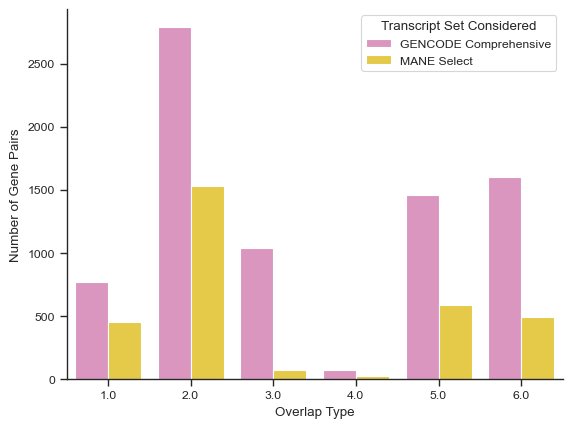

In [93]:
all_tss_overlap_count = GW_ensembl_protein_coding_df.groupby("overlap type").size().reset_index().rename(columns = {0:'num_gene'})
all_tss_overlap_count['Transcript Set Considered'] = 'GENCODE Comprehensive'
mane_overlap_count = GW_mane_protein_coding_df.groupby("overlap type").size().reset_index().rename(columns = {0:'num_gene'})
mane_overlap_count['Transcript Set Considered'] = 'MANE Select'

plot_df = pd.concat([all_tss_overlap_count,mane_overlap_count]).reset_index(drop=True)
default_palette = sns.color_palette("Set2")
sns.barplot(data = plot_df, x = 'overlap type', y = 'num_gene', hue = 'Transcript Set Considered',
           palette = {'GENCODE Comprehensive':default_palette[3],'MANE Select':default_palette[5]})
plt.xlabel('Overlap Type')
plt.ylabel('Number of Gene Pairs')
sns.despine()

gpp.savefig('../../Figures/Figure 6/num_overlapping_gene_sets_gencode_comprehensive_vs_mane.pdf', dpi=300, bbox_inches='tight')